In [4]:
!pip install qiskit_ibm_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.3 MB/s eta 0:00:00


In [239]:
import numpy as np 
import matplotlib.pyplot as plt
from qiskit import *                 
from qiskit_aer import *             
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import *
from collections import defaultdict

In [260]:
#user_num = int(input("Enter the max for your QRNG range:"))   # User input for max range 
#num_qubits = int(np.ceil(np.log2(user_num)))                  # Obtains number of qubits for the circuit
num_qubits = 2

In [261]:
def number_generator_simulator(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)                 # Creates circuit with number of qubits obtained
    circ.h(range(num_qubits))                                     # Applies a hadamard gate to all qubits
    circ.measure(range(num_qubits), range(num_qubits))            # Measures all qubits and assigns them to classical bits

    simulator = AerSimulator()                                         # Lets us use the Aer Simulator 
    compiled_circuit = transpile(circ, simulator)                      # Compiled circuit using Aer 
    result = simulator.run(compiled_circuit, shots = 50).result()     # Result with the 10000 shots as to not run forever on IBM machines
    counts = result.get_counts()                                       # Assigns counts with the result
    
    return counts

In [262]:
# For mod 2 method
def obtain_rand(counts):
    # Get all values
    max_value = max(counts.values())
    max_keys = [key for key, value in counts.items() if value == max_value]
    max_dict = {key: counts[key] for key in max_keys}
    # Sum all Q-bit entries for tied keys
    new_key = [int(i) for i in max_keys[0]]
    for i in range(1, len(max_keys) - 1):
        for j in range (0, num_qubits):
            new_key[j] += int(max_keys[i][j])

    super_new_key = ''
    # Bitwise XOR (mod % 2) on each qubit
    for i in range (0, num_qubits):
        # super_new_key[i] = str(int(new_key[i]) % 2)
        super_new_key += str(int(new_key[i]) % 2)

    return super_new_key
            
            

In [263]:
# For iterative method
def obtain_ties(counts):
    max_value = max(counts.values())
    max_keys = [key for key, value in counts.items() if value == max_value]
    max_dict = {key: counts[key] for key in max_keys}

    while (len(max_keys) > 1):
        # print(max_keys)
        max_keys = tie_breaker(max_keys)

    return max_keys[0]
        

def tie_breaker(ties):
    new_num_qubits = int(np.ceil(np.log2(len(ties))))
    # print("new q: ", new_num_qubits)
    counts = number_generator_simulator(new_num_qubits)
    # Discard out of range
    counts = {key: value for key, value in counts.items() if int(key,2) < len(ties)}
    
    max_value = max(counts.values()) # Max among the ties
    max_keys = [key for key, value in counts.items() if value == max_value] # Keys (indexes!) that tied
    max_dict = {key: counts[key] for key in max_keys} # Dictionary of tied index->value's
    # print("Max key: ", max_keys)
    
    # Need to use new ties (indexes of original ties) to index which ties make it
    new_ties = []
    # print(max_keys)
    for key in max_keys:
        # Ensure that 'key' is treated correctly for indexing
        index = int(key, 2)  # Convert binary string key to integer
        new_ties.append(ties[index])  # Append the corresponding original tie

    return new_ties

In [264]:
# Memory limitations (simulator only 30) -> "chunk" bit input
# chunk_size is # of qubits to divide chunk in to
def iterativeChunker(chunk_size):
    finalRN = ''
    for i in range (0, int(num_qubits/chunk_size)):
        counts = number_generator_simulator(chunk_size)
        rand_value = obtain_ties(counts)
        finalRN += rand_value

    remainderSize = num_qubits - np.floor(num_qubits/chunk_size)*chunk_size
    if remainderSize != 0:
        counts = number_generator_simulator(remainderSize)
        rand_value = obtain_ties(counts)
        finalRN += rand_value

    return finalRN

def modChunker(chunk_size):
    finalRN = ''
    for i in range (0, int(num_qubits/chunk_size)):
        counts = number_generator_simulator(chunk_size)
        rand_value = obtain_rand(counts)
        finalRN += rand_value

    remainderSize = num_qubits - np.floor(num_qubits/chunk_size)*chunk_size
    if remainderSize != 0:
        counts = number_generator_simulator(remainderSize)
        rand_value = obtain_ties(counts)
        finalRN += rand_value

    return finalRN

In [221]:
# Using iterative method
chunk_size = 30
for i in range (0, 100):
    final_val = iterativeChunker(chunk_size)
    print(f'Final random qubit state:', final_val)

Final random qubit state: 110000011010011111001100001011
Final random qubit state: 011100010111100000100111100010
Final random qubit state: 100111100000101101000001111111
Final random qubit state: 010001000110111001010101010001
Final random qubit state: 001101111111100110100111100100
Final random qubit state: 110011100100111001101010011101
Final random qubit state: 110010001100111100001010110110
Final random qubit state: 001101011011000011110110110111
Final random qubit state: 000110110000000100101101010110
Final random qubit state: 011010110010001110001111100111
Final random qubit state: 011111010011100010001111001111
Final random qubit state: 000111110001100110001011001100
Final random qubit state: 111110010001011110101111110101
Final random qubit state: 101100100100001011101100010100
Final random qubit state: 101111100011001010111001011111
Final random qubit state: 000001011111101110110000010111
Final random qubit state: 000011110000110100110101001001
Final random qubit state: 11101

In [231]:
# Using mod 2 method
for i in range (0, 100):
    rand_value = modChunker(chunk_size)
    # print(f'Data:', counts)
    print(f'Final random qubit state:', rand_value)



Final random qubit state: 101100111101010001011011110111
Final random qubit state: 000011101011000011100001011000
Final random qubit state: 100101001111101100000010110001
Final random qubit state: 101000100111000100000001111111
Final random qubit state: 111011111001011010000000001010
Final random qubit state: 011010110011000110100101111000
Final random qubit state: 011001110001100110011110101011
Final random qubit state: 000001111110100001010101110011
Final random qubit state: 101001001100001000101111000111
Final random qubit state: 000111001111011010001100010101
Final random qubit state: 001011001001110001110011100010
Final random qubit state: 001100110001110100000111000111
Final random qubit state: 111000010100010110111010111100
Final random qubit state: 111101101110101111100100001110
Final random qubit state: 001000100001000101000110000111
Final random qubit state: 000000101000001000011111011010
Final random qubit state: 001010100100101111111010100011
Final random qubit state: 11000

In [285]:
# num_qubits = 10
# modDict = {}
# for i in range (0, 2**num_qubits - 1):
#     modDict.update({i:0})
num_qubits = 5

modDict = { i:0 for i in range(0,2**num_qubits)}


for i in range (0, 1000):
    counts = number_generator_simulator(num_qubits)
    rand_val = obtain_rand(counts)
    modDict[int(rand_val,2)] += 1


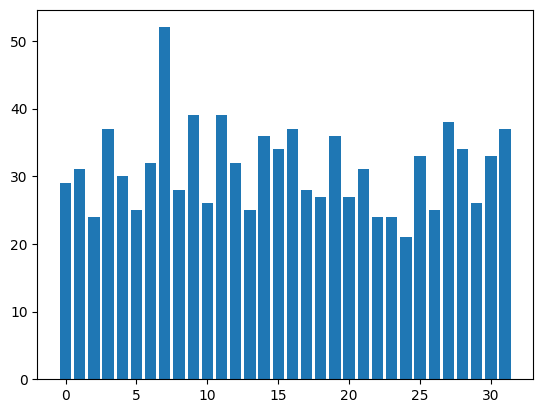

In [286]:
plt.bar(modDict.keys(), modDict.values())
plt.show()

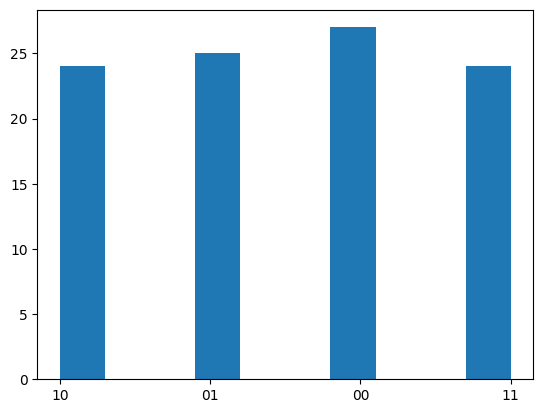

In [269]:
modDict = []
for i in range (0, 100):
    counts = number_generator_simulator(num_qubits)
    rand_value = obtain_ties(counts)
    modDict.append(rand_value)
plt.hist(modDict)
plt.show()